In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate as si

Damped harmonic oscillator for Lorentz model:
$$
\begin{align}
\ddot x + 2 \gamma \dot x + \omega_0 x = -\frac{e}{m} E(t)
\end{align}
$$

Fourier transform:
$$
\begin{align}
\left[
    - \omega^2 - 2 {\rm i} \gamma \omega + \omega_0^2
\right]
x (\omega)
&=
-\frac{e}{m} E(\omega)
\\
\implies
x(\omega)
&=
\frac{e}{m}
\frac{1}{\omega^2 + 2 {\rm i} \gamma \omega - \omega_0^2}
\end{align}
$$

In [2]:
w0 = 5  # Eigenfrequency
gamma = .2  # damping
ws = np.linspace(-20, 20, 1000)

fs = 1 / (ws ** 2 + 2.0j * gamma * ws - w0 ** 2)

# fs = 1 / (ws - w0 + 1.0j * gamma) / 2 / w0 - 1 / (ws + w0 + 1.0j * gamma) / 2 / w0

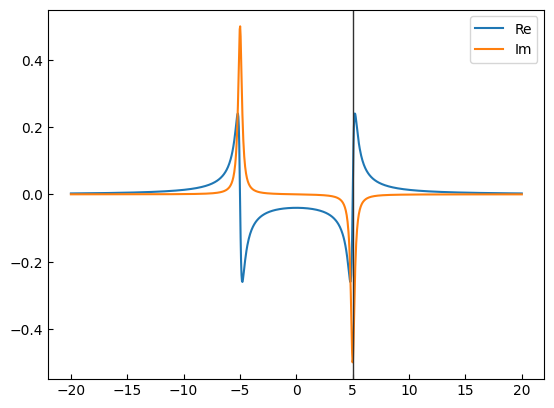

In [3]:
fig, ax = plt.subplots()

ax.plot(ws, fs.real)
ax.plot(ws, fs.imag)

ax.legend(["Re", "Im"])

ax.axvline(w0, color="#313131", lw=1)

## KK transform

$$
\begin{align}
\chi_1(\omega)=\frac{1}{\pi} \mathcal{P} \int_{-\infty}^{\infty} \frac{\chi_2\left(\omega^{\prime}\right)}{\omega^{\prime}-\omega} d \omega^{\prime}
\end{align}
$$
and
$$
\begin{align}
\chi_2(\omega)=-\frac{1}{\pi} \mathcal{P} \int_{-\infty}^{\infty} \frac{\chi_1\left(\omega^{\prime}\right)}{\omega^{\prime}-\omega} d \omega^{\prime}
\end{align}
$$

### Numerically:

$$
\begin{align}
\chi_2(\omega)
&=
-\frac{1}{\pi} \mathcal{P} \int_{-\infty}^{\infty} \frac{\chi_1\left(\omega^{\prime}\right)}{\omega^{\prime}-\omega} d \omega^{\prime}
=
-\frac{1}{\pi} 
\lim_{\color{red} \eta \to 0}
\int_{-\infty}^{\infty} 
\frac{\chi_1\left(\omega^{\prime}\right)}{\omega^{\prime}-\omega + {{\rm i} \color{red} \eta} } d \omega^{\prime}
\end{align}
$$

### With squares:

$$
\begin{align}
\chi_1(\omega)
&=
\frac{2}{\pi} \mathcal{P} \int_0^{\infty} \frac{\omega^{\prime} \chi_2\left(\omega^{\prime}\right)}{\omega^{\prime 2}-\omega^2} d \omega^{\prime}
\\
\chi_2(\omega)
&=
-\frac{2}{\pi} \mathcal{P} \int_0^{\infty} \frac{\omega \chi_1\left(\omega^{\prime}\right)}{\omega^{\prime 2}-\omega^2} d \omega^{\prime}
\end{align}
$$

### Numerically:

$$
\begin{align}
\chi_2(\omega)
&=
-\frac{2}{\pi} \mathcal{P} \int_0^{\infty} \frac{\omega \chi_1\left(\omega^{\prime}\right)}{\omega^{\prime 2}-\omega^2} d \omega^{\prime}
=
- \frac{2}{\pi}
\lim_{\color{red} \eta \to 0}
\int_0^{\infty} \frac{\omega \chi_1\left( \omega^{\prime}\right)}{ (\omega^{\prime} + {\rm i} \color{red} \eta)^2-\omega^2} d \omega^{\prime}
\end{align}
$$

In [4]:
def get_kk_imag_from_real_vectorized(xs: np.ndarray, ys: np.ndarray, eta: float = 1e-5):
    """Only faster for small problems"""
    assert len(xs) == len(ys)

    mask = xs >= 0

    chi1 = ys.copy()[mask]
    chi2 = np.zeros_like(ys)

    ws = xs[mask]

    dw = (ws[None, :] + 1.0j * eta) ** 2 - xs[:, None] ** 2

    integrand = (xs[:, None] * chi1[None, :] / dw).real

    chi2 = -2 * np.sum(integrand, axis=1) / np.pi * (ws[1] - ws[0])

    return chi2

In [5]:
def get_kk_imag_from_real_linear(xs: np.ndarray, ys: np.ndarray, eta: float = 1e-5):
    """"""
    assert len(xs) == len(ys)

    chi1 = ys.copy()
    chi2 = np.zeros_like(ys)

    for ii, x in enumerate(xs):

        dw = xs - x + eta * 1.0j

        integrand = (chi1 / dw).real

        chi2[ii] = -si.trapezoid(integrand, x=xs) / np.pi

    return chi2


def get_kk_real_from_imag_linear(xs: np.ndarray, ys: np.ndarray, eta: float = 1e-8):
    """"""
    return -get_kk_imag_from_real_linear(xs=xs, ys=ys, eta=eta)

In [6]:
def get_kk_imag_from_real(xs: np.ndarray, ys: np.ndarray, eta: float = 1e-5):
    """"""
    assert len(xs) == len(ys)

    mask = xs >= 0

    chi1 = ys.copy()
    chi2 = np.zeros_like(ys)

    for ii, x in enumerate(xs):

        dw = (xs[mask] + eta * 1.0j) ** 2 - (x) ** 2  #  + eta * 1.0j

        integrand = (x * chi1[mask] / dw).real

        chi2[ii] = -2 * np.sum(integrand) / np.pi * (xs[1] - xs[0]).real

    return chi2


def get_kk_real_from_imag(xs: np.ndarray, ys: np.ndarray, eta: float = 1e-5):
    """"""
    assert len(xs) == len(ys)

    mask = xs >= 0

    chi1 = ys.copy()
    chi2 = np.zeros_like(ys)

    for ii, x in enumerate(xs):

        dw = (xs[mask] + eta * 1.0j) ** 2 - (x) ** 2  #  + eta * 1.0j

        integrand = (xs[mask] * chi1[mask] / dw).real

        chi2[ii] = 2 * np.sum(integrand) / np.pi * (xs[1] - xs[0]).real

    return chi2

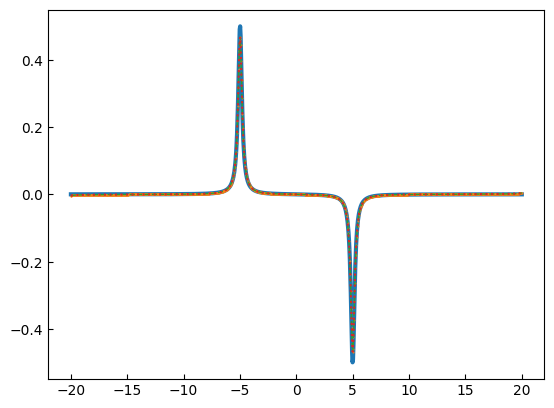

In [7]:
fig, ax = plt.subplots()

ax.plot(ws, fs.imag, lw=3)
ax.plot(ws, get_kk_imag_from_real(ws, fs.real), marker=".", lw=0, ms=1)
ax.plot(ws, get_kk_imag_from_real_linear(ws, fs.real), lw=1, ls="--")
ax.plot(ws, get_kk_imag_from_real_vectorized(ws, fs.real), ls=":")  # marker="x", lw=0)

# ax.set_xlim(-1, 1)
# ax.set_ylim(-0.1, 0.1)

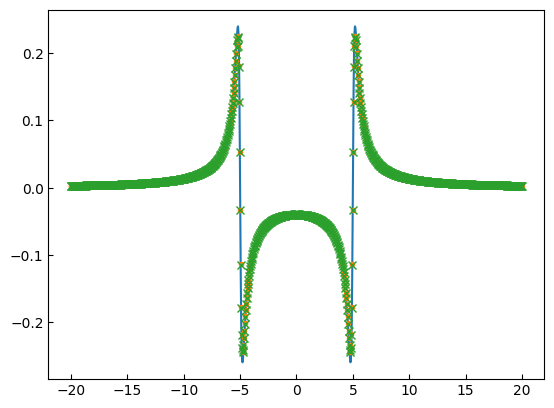

In [8]:
fig, ax = plt.subplots()

ax.plot(ws, fs.real)
ax.plot(ws, get_kk_real_from_imag(ws, fs.imag), marker=".", lw=0)
ax.plot(ws, get_kk_real_from_imag_linear(ws, fs.imag), marker="x", lw=0)

# ax.set_xlim(-20, 20)

In [9]:
%%timeit
get_kk_imag_from_real(ws, fs.real)

8.46 ms ± 62.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
get_kk_imag_from_real_vectorized(ws, fs.real)

3.13 ms ± 52.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
